In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

import Pyro4.util

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(
c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Warning serial library import failed.
Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A
Could not load InstrumentManagerWindow
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amprabi_opt_ctrl_state_prep
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.crosstalk_echo_calib
imp

In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_240617


In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


Load config

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.272
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=43

In [11]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

Default Instrument SC_26C1


0

# ZZ shift qspec to get 4x4 ZZ matrix

In [9]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

In [12]:
for qTest in range(4): # qubit to measure
    # for qZZ in range(4): # qubit to pulse to e
    for qZZ in range(4): # qubit to pulse to e
        # if qTest != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        # if qTest != 1 and qZZ != 1: continue
        # if qTest == 1 or qZZ == 1: continue
        # if qTest == 0 and qZZ == 1: continue
        if qZZ == qTest: continue
        print('qTest', qTest, 'qZZ', qZZ)

        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qTest}{qZZ}",
            config_file=config_path,
        )
        
        span = 20
        npts = 251
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qTest]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=8, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=1.0, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qTest]/80), # pulse gain for qubit we are measuring
            pulse_type='gauss',
            qubits=[qTest, qZZ],
            checkEF=False,
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qTest} due to Q{qZZ} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        ZZshifts[qTest, qZZ] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qTest]
        print(f'Fit Q{qTest} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qTest} shift due to Q{qZZ} in e [MHz]: {ZZshifts[qTest, qZZ]}')

        yaml_cfg.device.qubit.ZZs = ZZshifts.flatten()

        if qTest == 1: yaml_cfg.device.qubit.f_Q1_ZZ[qZZ] = qZZspec_fit[2]
        else: yaml_cfg.device.qubit.f_Q_ZZ1[qTest] = qZZspec_fit[2]

print(ZZshifts)

qTest 0 qZZ 1


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
# ZZshifts[0,:] = ZZshifts[:,0]
# print(ZZshifts)

Optional: update manual config now, or just keep running the T2R calibration cell using the already updated yaml_cfg variable

In [17]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.310354797166383, -0.1043071446219983, -0.5526523031812758, -5.310354797166383, 0.0, -1.0669915496569047, -1.303849560098115, -0.1043071446219983, -1.0938287529179433, 0.0, -0.48324088539629884, -0.5526523031812758, -1.310921911920559, -0.5275917408453097, 0.0]


In [18]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]).flatten(), sep=', ', end=']\n')
print(f'f_Q_ZZ1: [', end='')
print(*(ZZshifts[:,1] + yaml_cfg.device.qubit.f_ge[:]).flatten(), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3442.876608141103, 3448.1869629382695, 3447.1199713886126, 3446.8831133781714]
f_Q_ZZ1: [4105.2374168703445, 3448.1869629382695, 4761.155245235079, 4379.464870657291]


EF shift due to Q1 in e

qTest 2 qZZ 1


  0%|          | 0/8 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4570.477670456904, HWHM 0.20133640505245753
Found peak in I at [MHz] 4570.464877589618, HWHM 0.21589187951766206
Found peak in Q at [MHz] 4570.478871579078, HWHM 0.20203521481400372


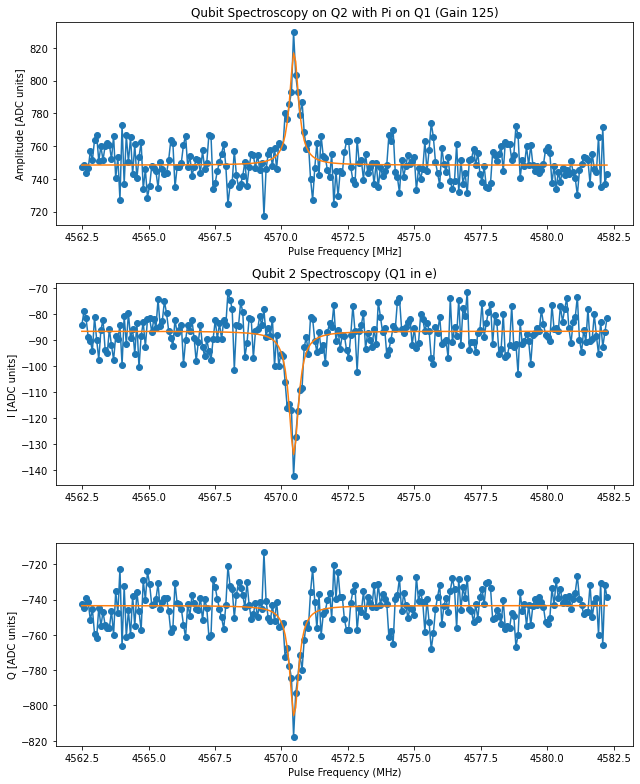

best 1 0.05912204177052394
Fit Q2 ef frequency with ZZ shift [MHz]: 4570.464877589618
Q2 ef shift due to Q1 in e [MHz]: 0.0
qTest 3 qZZ 1


  0%|          | 0/8 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4214.154424268595, HWHM 4.7423642053406745
Found peak in I at [MHz] 4207.556550033356, HWHM 2.7097765801217912
Found peak in Q at [MHz] 4212.692899784775, HWHM -4.929548353884321


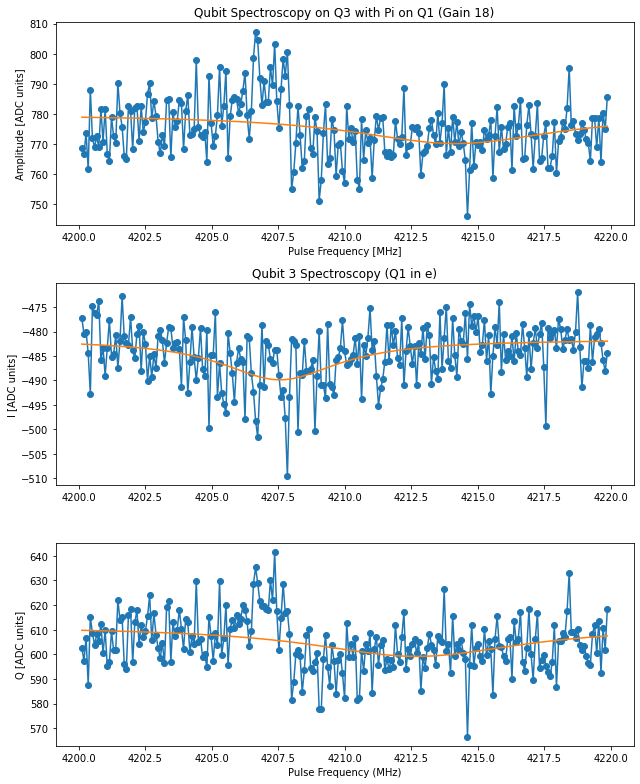

best 1 0.10318465053625234
Fit Q3 ef frequency with ZZ shift [MHz]: 4207.556550033356
Q3 ef shift due to Q1 in e [MHz]: 0.0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [11]:
for qTest in [2, 3]: # qubit to measure ef
    for qZZ in [1]: # qubit to pulse to e
        # if qTest != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        # if qTest != 1 and qZZ != 1: continue
        # if qTest == 1 or qZZ == 1: continue
        # if qTest == 0 and qZZ == 1: continue
        if qZZ == qTest: continue
        print('qTest', qTest, 'qZZ', qZZ)

        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qTest}{qZZ}",
            config_file=config_path,
        )
        
        span = 20
        npts = 251
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ef[qTest]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=8, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            checkEF=True,
            length=1.0, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ef.gain[qTest]/80), # pulse gain for qubit we are measuring
            pulse_type='gauss',
            qubits=[qTest, qZZ],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qTest} due to Q{qZZ} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        print(f'Fit Q{qTest} ef frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qTest} ef shift due to Q{qZZ} in e [MHz]: {ZZshifts[qTest, qZZ]}')

        yaml_cfg.device.qubit.f_ef_Q_ZZ1[qTest] = qZZspec_fit[2]

print(ZZshifts)

# ZZ shifted pi pulse calibrations for pi_Q1_ZZ and pi_Q_ZZ1

## Functions for experiments

In [137]:
def run_length_rabi(qZZ, qTest, yaml_cfg, checkEF=False, save_data=True):
    assert qZZ != qTest
    print(f"-------- length rabi --------")
    lengthrabiZZ = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_ZZ_qubit{qZZ}{qTest}",
        config_file=config_path,
    )
    lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    if qTest == 1: gain = yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[qZZ]
    else: gain = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qTest]
    if checkEF:
        if qTest == 1: gain = yaml_cfg.device.qubit.pulses.pi_ef_Q1_ZZ.gain[qZZ]
        else: gain = yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.gain[qTest]

    lengthrabiZZ.cfg.expt = dict(
        start=0, # pulse length (sigma) [us]
        step=soc.cycles2us(1), # [us]
        expts=101,
        reps=1000,
        gain=gain,
        pulse_type='gauss',
        qubits=[qZZ, qTest],
        checkZZ=True,
        checkEF=checkEF, 
    )

    try:
        lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    lengthrabiZZ.analyze(fit=True)
    
    lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
    lengthrabiZZ.display(fit=True)
    p = lengthrabi_fit
    if p[2] > 180: p[2] = p[2] - 360
    elif p[2] < -180: p[2] = p[2] + 360
    if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
    else: pi_len = (3/2 - p[2]/180)/2/p[1]
    pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

    if save_data: lengthrabiZZ.save_data()

    return pi_len

In [149]:
def run_amp_rabi(qZZ, qTest, yaml_cfg, checkEF=False, save_data=True):
    print(f"-------- Amp rabi --------")

    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{qZZ}{qTest}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    if qTest == 1: old_gain = yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[qZZ]
    else: old_gain = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qTest]
    if checkEF:
        if qTest == 1: old_gain = yaml_cfg.device.qubit.pulses.pi_ef_Q1_ZZ.gain[qZZ]
        else: old_gain = yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.gain[qTest]
    span = min((32000, 1.5*old_gain))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=100,
        rounds=10,
        pulse_type='gauss',
        checkZZ=True,
        checkEF=checkEF, 
        qubits=[qZZ, qTest],
    )

    try:
        amprabi.go(analyze=False, display=False, progress=True, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    amprabi.analyze(fit=True)

    amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

    p = amprabi_fit
    if p[2] > 180: p[2] = p[2] - 360
    elif p[2] < -180: p[2] = p[2] + 360
    if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    else: pi_gain = (3/2 - p[2]/180)/2/p[1]

    if pi_gain > 32000:
        amprabi.display(fit=False)
        print('WARNING: Fit pi pulse gain is long, please double check!')
        pi_gain = 30000
    else: amprabi.display(fit=True)

    if save_data: amprabi.save_data()

    return int(pi_gain)

In [139]:
def run_ramsey(qZZ, qTest, yaml_cfg, checkEF=False, save_data=True):

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qTest}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=2.5, # [MHz]
        reps=100,
        rounds=10,
        checkZZ=True,
        checkEF=checkEF,
        qubits=[qZZ, qTest],
    )
    
    ramsey.go(analyze=False, display=False, progress=True, save=False)
    ramsey.analyze(fit=True)

    ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

    ramsey.display(fit=True)

    if save_data: ramsey.save_data()

    if checkEF:
        if qTest == 1: return yaml_cfg.device.qubit.f_ef_Q1_ZZ[qZZ] + ramsey_adjust[0]
        else: return ramsey.cfg.device.qubit.f_ef_Q_ZZ1[qTest] + ramsey_adjust[0]
    if qTest == 1: return yaml_cfg.device.qubit.f_Q1_ZZ[qZZ] + ramsey_adjust[0]
    else: return ramsey.cfg.device.qubit.f_Q_ZZ1[qTest] + ramsey_adjust[0]


In [162]:
def run_error_amp(qZZ, qTest, yaml_cfg, checkEF=False, save_data=True):

    print(f"-------- Error amplification --------")

    npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{qZZ}{qTest}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
    npulsecalib.cfg.expt = dict(
        start=0, # number gate repetitions
        step=1,
        expts=4,
        reps=1000,
        loops=20,
        pulse_type='gauss',
        checkZZ=True,
        checkEF=checkEF, 
        qubits=[qZZ, qTest],
        test_pi_half=False,

        post_process='scale',
        singleshot_reps=15000,
        # thresholds=thresholds,
        # angles=angles,
        # ge_avgs=ge_avgs,
        # counts_calib=counts_calib,
    )

    # print(npulsecalib.cfg)
    import Pyro4.util
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))


    # temp_data, attrs = prev_data(expt_path, f'00000_NPulseExptQ{qZZ}{qTest}.h5')
    # npulsecalib.cfg = AttrDict(attrs['config'])
    # npulsecalib.data = temp_data

    data = npulsecalib.data

    npulsecalib.analyze(fit=True)
    npulsecalib.display(fit=True)
    
    npulsecalib_fit, npulsecalib_fit_err = meas.fitting.get_best_fit(npulsecalib.data)
    
    angle_err = npulsecalib_fit[1]
    amp_ratio = (180 - angle_err) / 180

    if qTest == 1: old_gain = npulsecalib.cfg.device.qubit.pulses.pi_Q1_ZZ.gain[qZZ]
    else: old_gain = npulsecalib.cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qTest]
    if checkEF:
        if qTest == 1: old_gain = npulsecalib.cfg.device.qubit.pulses.pi_ef_Q1_ZZ.gain[qZZ]
        else: old_gain = npulsecalib.cfg.device.qubit.pulses.pi_ef_Q_ZZ1.gain[qTest]

    pi_gain = old_gain / amp_ratio

    if save_data: npulsecalib.save_data()

    return int(round(pi_gain))

## Run the experiment loop

In [163]:
save_data = False
saved_files = []

In [164]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [165]:
results = dict(
    pi_Q1_ZZ_gain = [0]*4,
    pi_Q1_ZZ_sigma = [0]*4,
    f_Q1_ZZ = [0]*4,
    pi_Q_ZZ1_gain = [0]*4,
    pi_Q_ZZ1_sigma = [0]*4,
    f_Q_ZZ1 = [0]*4,
)

In [166]:
do_length_rabi = False
do_amp_rabi = False
# do_ramsey = True
do_ramsey = True
# do_amp_rabi_2 = True
do_amp_rabi_2 = False
do_error_amp = True

# put an override=True flag to force skipping certain qubits

######### BEGINNING QUBIT 1 WITH ZZ FROM 0 #########
initial pi_len 0.025
initial pi_gain 2803
initial pi_freq 3442.909184486008
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.18159455201321242
Current pi pulse frequency: 3442.909184486008
Fit frequency from amps [MHz]: 2.571204980353312 +/- 0.0013493716144481569
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3442.837979505655
 	3437.837979505655
T2 Ramsey from fit amps [us]: 103.17051822319485 +/- 90.57156296939903
Current pi pulse frequency: 3442.909184486008
Fit frequency from I [MHz]: 2.5710324947411114 +/- 0.0014222058304066494
Suggested new pi pulse frequency from fit I [MHz]:
 	3442.838151991267
 	3437.838151991267
T2 Ramsey from fit I [us]: 108.52689247853594 +/- 105.64724329536854
Fit frequency from Q [MHz]: 2.572011023190686 +/- 0.001727535946166915
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3442.8371734628176
 	3437.8371734628176
T2 Ramsey from fit Q [us]: 123.02343757094113 +/- 164.77497478766853


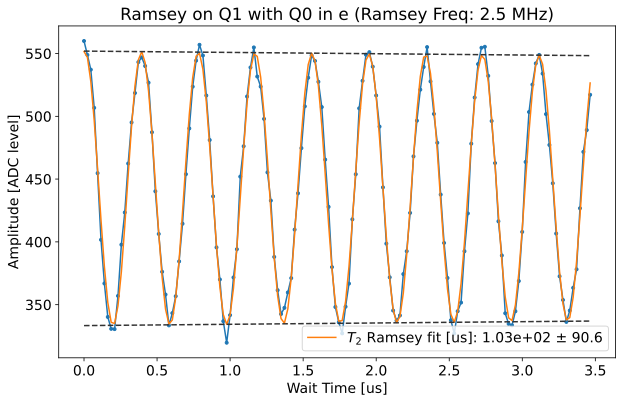

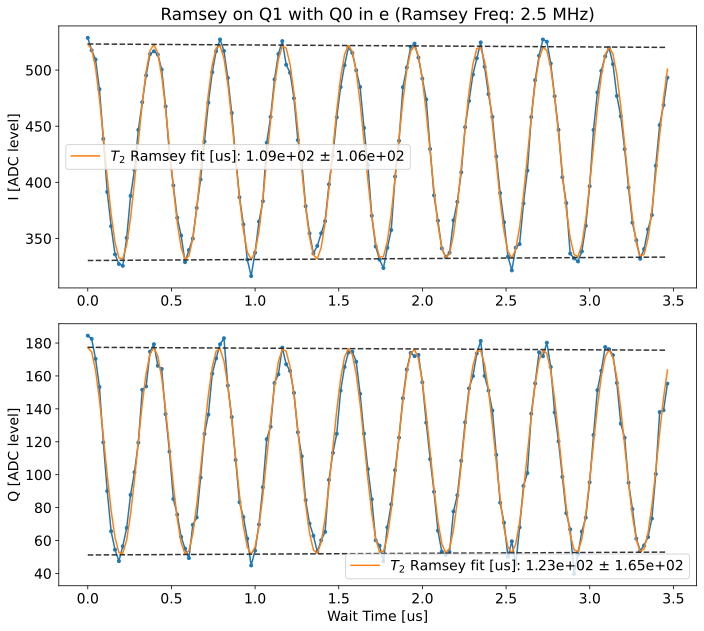

updated pi_freq 3442.837979505655
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 63.67333333333334 	 angle (deg): -40.36300920513896 	 threshold ge: 397.02883535156553


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 359RuntimeWarning: divide by zero encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 360

From amps: adjust amplitude to 2803 / 0.9872264400394208 = 2839.2675543496116


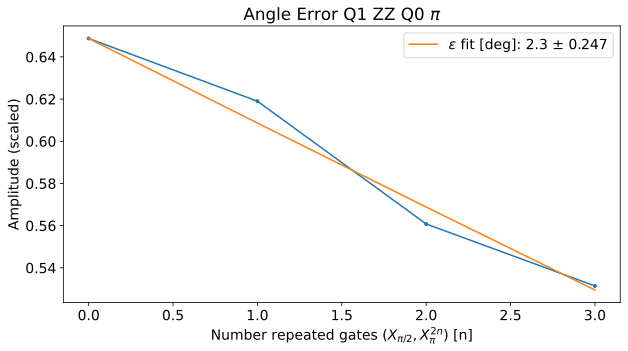

From avgi: adjust amplitude to 2803 / 0.9872152909471907 = 2839.299619549695

From avgq: adjust amplitude to 2803 / 1.000009309559807 = 2802.9739055467885


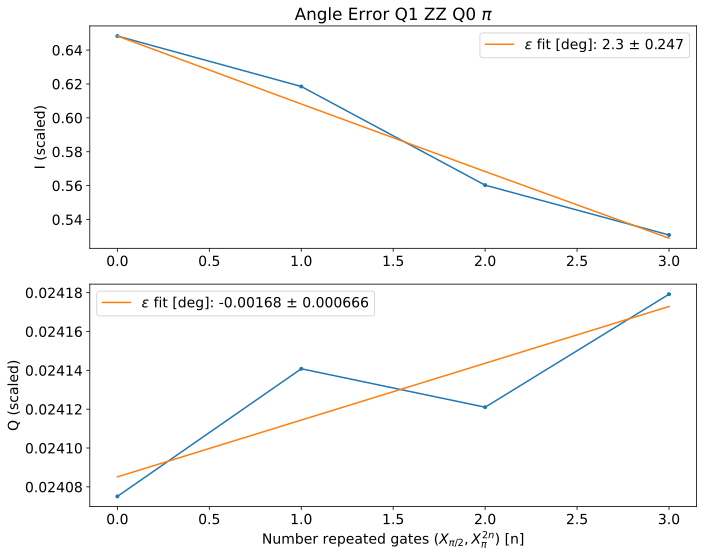

best 0 0.05972989459972385
updated pi_gain from error amplification 2839



######### BEGINNING QUBIT 0 WITH ZZ FROM 1 #########
initial pi_len 0.02
initial pi_gain 1983
initial pi_freq 4104.8259754819555
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

best 2 0.022259315493037994
Current pi pulse frequency: 4104.8259754819555
Fit frequency from amps [MHz]: 2.2640650822794677 +/- 0.0010851327542252581
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4105.061910399676
 	4100.061910399676
T2 Ramsey from fit amps [us]: 15.404329310439335 +/- 1.630564715821505
Current pi pulse frequency: 4104.8259754819555
Fit frequency from I [MHz]: 2.2641550958727676 +/- 0.0011452287558222215
Suggested new pi pulse frequency from fit I [MHz]:
 	4105.061820386083
 	4100.061820386083
T2 Ramsey from fit I [us]: 16.81832042281634 +/- 2.052094105362735
Fit frequency from Q [MHz]: 2.2641985017293322 +/- 0.0010619532389791317
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4105.061776980227
 	4100.061776980227
T2 Ramsey from fit Q [us]: 13.072120140376262 +/- 1.1480238864804333


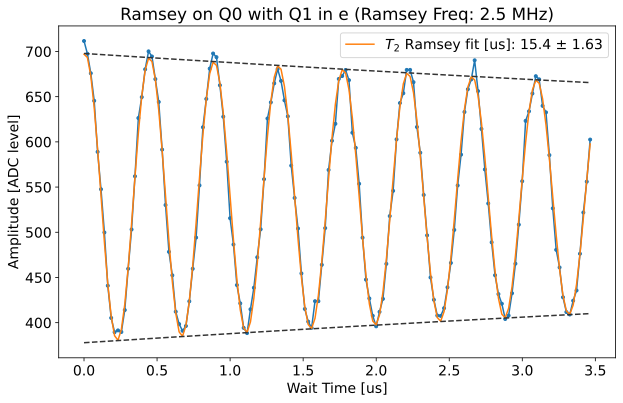

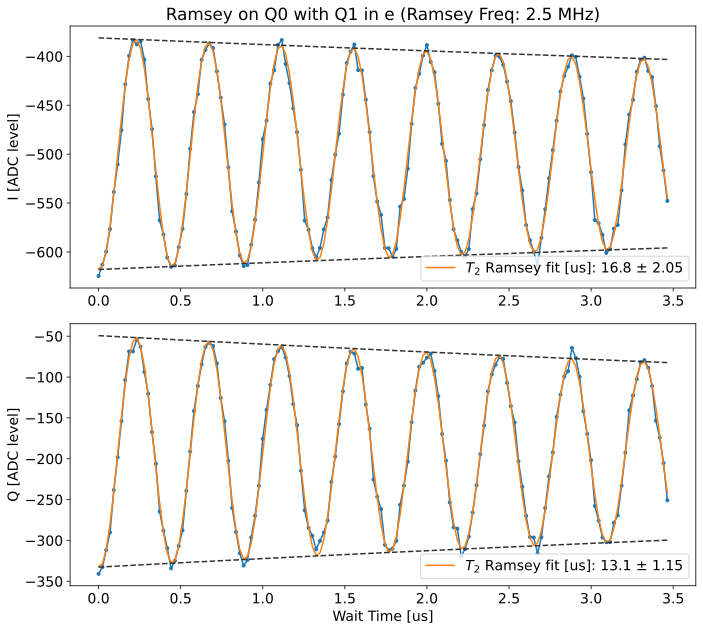

updated pi_freq 4105.061776980227
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 75.64666666666666 	 angle (deg): 135.05991833803824 	 threshold ge: 476.3398500613887


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 359RuntimeWarning: divide by zero encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 360

From amps: adjust amplitude to 1983 / 1.041323062163422 = 1904.3081557035507


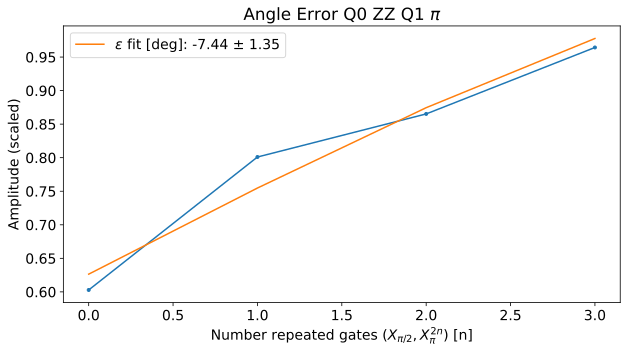

From avgi: adjust amplitude to 1983 / 1.0413571456440007 = 1904.245827951432

From avgq: adjust amplitude to 1983 / 0.9995848174065122 = 1983.823649047634


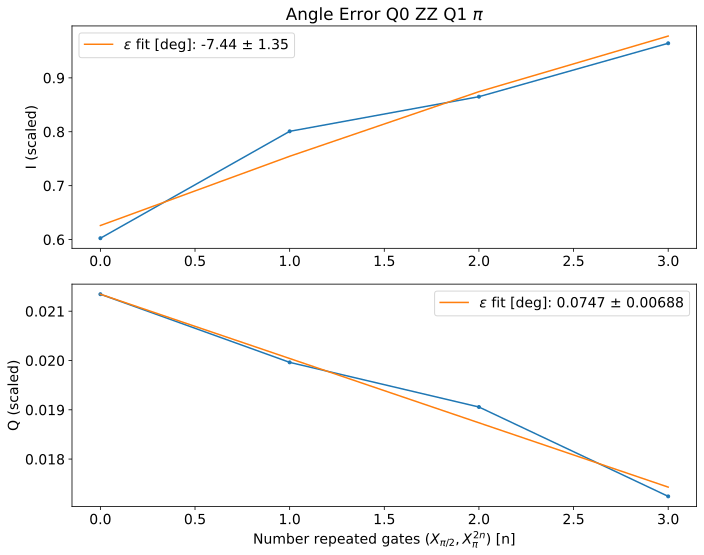

best 2 0.051297827466382104
updated pi_gain from error amplification 1984



######### BEGINNING QUBIT 2 WITH ZZ FROM 1 #########
initial pi_len 0.015
initial pi_gain 13766
initial pi_freq 4761.14068386677
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.020538022147544025
Current pi pulse frequency: 4761.14068386677
Fit frequency from amps [MHz]: 2.5557300995141716 +/- 0.0011062878416827795
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4761.084953767256
 	4756.084953767256
T2 Ramsey from fit amps [us]: 12.147216606362353 +/- 1.0358195433958806
Current pi pulse frequency: 4761.14068386677
Fit frequency from I [MHz]: 2.5556501598790575 +/- 0.0010353631145313548
Suggested new pi pulse frequency from fit I [MHz]:
 	4761.0850337068905
 	4756.0850337068905
T2 Ramsey from fit I [us]: 12.220643711699292 +/- 0.9812455861652014
Fit frequency from Q [MHz]: 2.5595518702770206 +/- 0.0036457911286852866
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4761.081131996493
 	4756.081131996493
T2 Ramsey from fit Q [us]: 9.393775932751119 +/- 2.0350894222171725


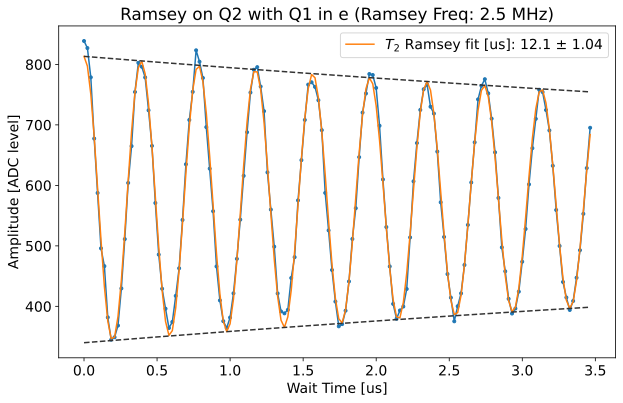

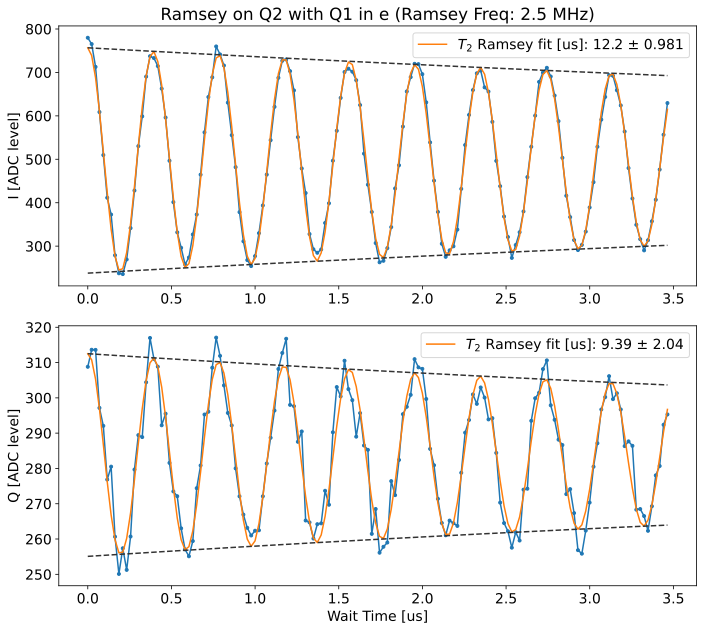

updated pi_freq 4761.0850337068905
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (2)
ge fidelity (%): 87.74666666666666 	 angle (deg): -4.553943187241117 	 threshold ge: 491.2924694940983


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 359RuntimeWarning: divide by zero encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 360

From amps: adjust amplitude to 13766 / 0.9574309294252823 = 14378.060679806245


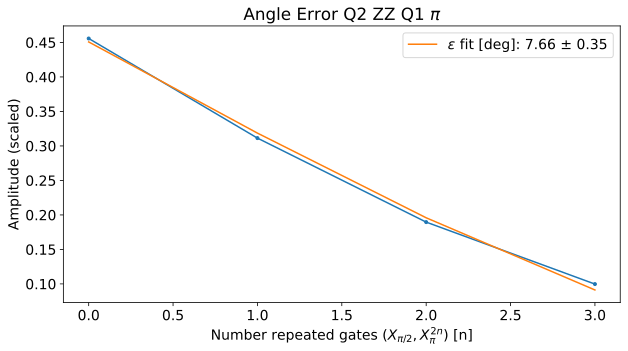

From avgi: adjust amplitude to 13766 / 0.9573638720193753 = 14379.067773847853

From avgq: adjust amplitude to 13766 / 0.9994417438567175 = 13773.6892466376


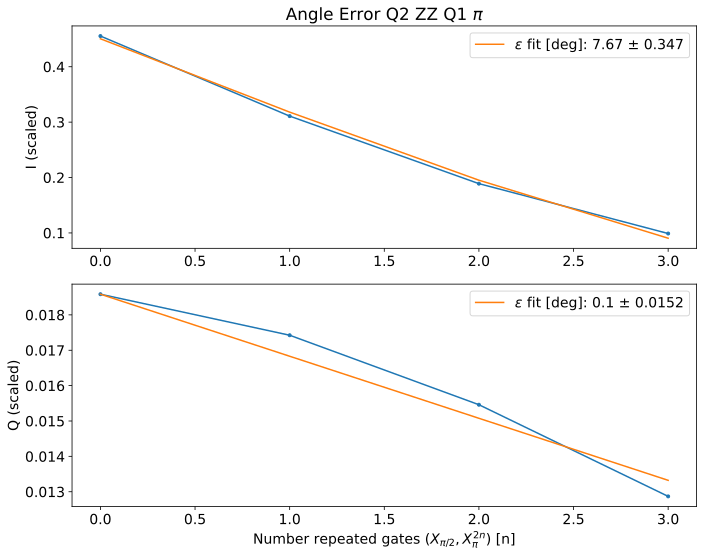

best 1 0.03227261125886331
updated pi_gain from error amplification 14379



######### BEGINNING QUBIT 3 WITH ZZ FROM 1 #########
initial pi_len 0.005
initial pi_gain 4779
initial pi_freq 4380.292188886469
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.026367038944586273
Current pi pulse frequency: 4380.292188886469
Fit frequency from amps [MHz]: 2.4355357268143143 +/- 0.0021436529566554144
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4380.356653159655
 	4375.356653159655
T2 Ramsey from fit amps [us]: 10.779276836177583 +/- 1.5556286487276059
Current pi pulse frequency: 4380.292188886469
Fit frequency from I [MHz]: 2.4362455868783766 +/- 0.0014922039960979694
Suggested new pi pulse frequency from fit I [MHz]:
 	4380.355943299591
 	4375.355943299591
T2 Ramsey from fit I [us]: 9.465343976686905 +/- 0.8344735780566814
Fit frequency from Q [MHz]: 2.4356135696599437 +/- 0.002236530178131757
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4380.3565753168095
 	4375.3565753168095
T2 Ramsey from fit Q [us]: 10.810554197339952 +/- 1.632538664969066


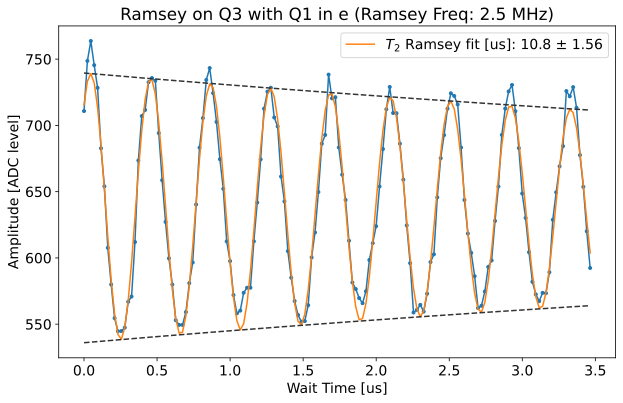

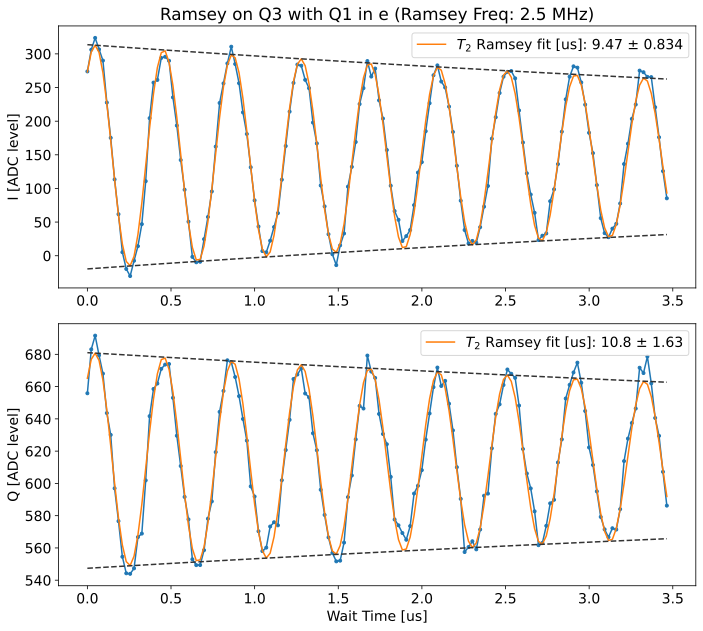

updated pi_freq 4380.355943299591
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (3)
ge fidelity (%): 82.03606786892897 	 angle (deg): -19.09949926239885 	 threshold ge: 344.2363344104258


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 359RuntimeWarning: divide by zero encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 360

From amps: adjust amplitude to 4779 / 1.0298411401413778 = 4640.521546210451


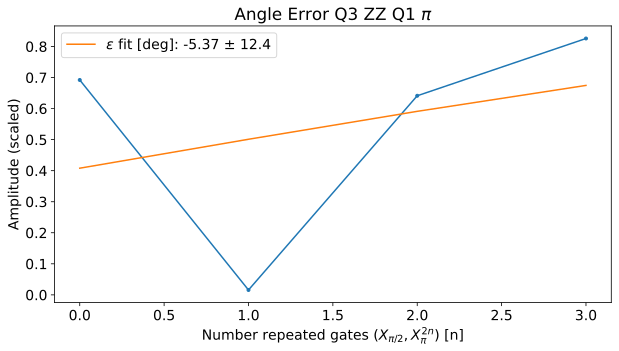

From avgi: adjust amplitude to 4779 / 1.030128193060175 = 4639.2284302045455

From avgq: adjust amplitude to 4779 / 1.000104219454914 = 4778.501987127596


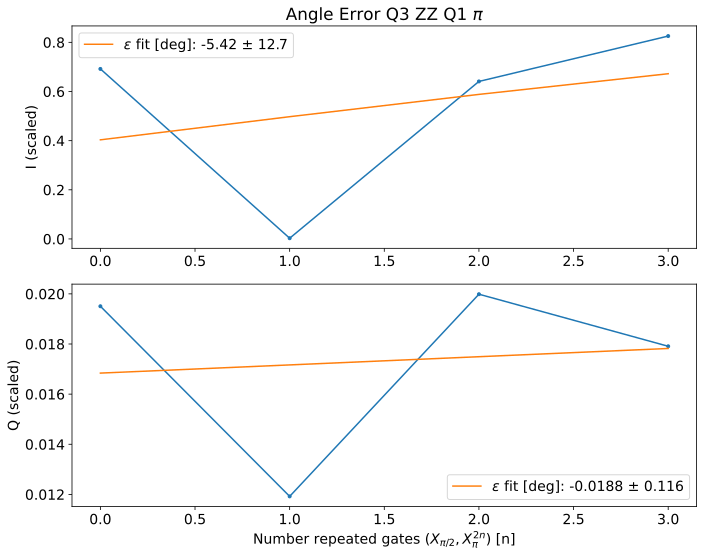

best 0 1.595734240258325
updated pi_gain from error amplification 4641



######### BEGINNING QUBIT 1 WITH ZZ FROM 2 #########
initial pi_len 0.02
initial pi_gain 3309
initial pi_freq 3447.0924878770584
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

best 2 0.049131893893940785
Current pi pulse frequency: 3447.0924878770584
Fit frequency from amps [MHz]: 2.4917834471315556 +/- 0.0016967164411018985
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3447.1007044299267
 	3442.1007044299267
T2 Ramsey from fit amps [us]: 20.52986881786782 +/- 4.307621281927307
Current pi pulse frequency: 3447.0924878770584
Fit frequency from I [MHz]: 2.492102722797548 +/- 0.001841290546448485
Suggested new pi pulse frequency from fit I [MHz]:
 	3447.100385154261
 	3442.100385154261
T2 Ramsey from fit I [us]: 21.786504512729323 +/- 5.263063809411644
Fit frequency from Q [MHz]: 2.4898230581892697 +/- 0.002030978897415219
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3447.102664818869
 	3442.102664818869
T2 Ramsey from fit Q [us]: 16.41260630699127 +/- 3.300608403496832


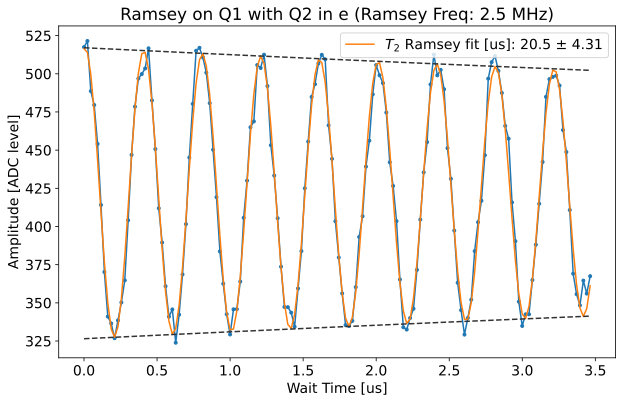

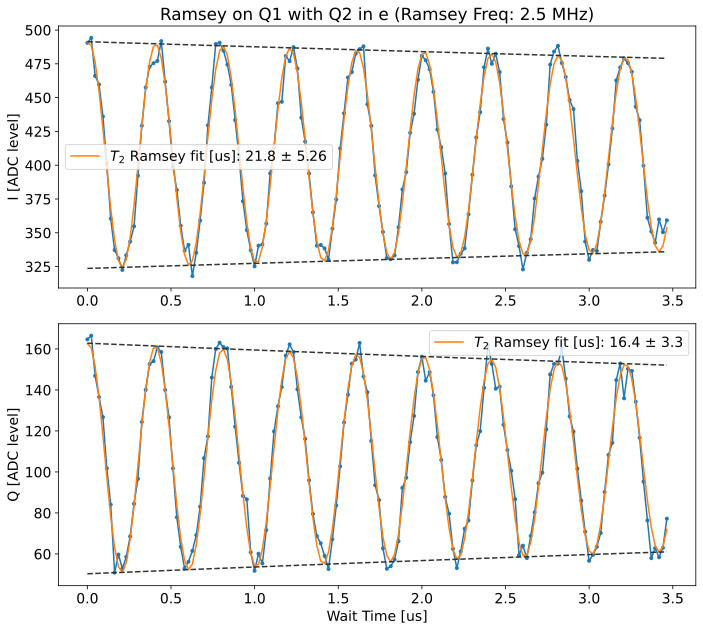

updated pi_freq 3447.102664818869
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 64.65333333333334 	 angle (deg): -41.111153826729065 	 threshold ge: 397.2018489567025


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 359RuntimeWarning: divide by zero encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 360

From amps: adjust amplitude to 3309 / 1.0431604371574306 = 3172.0911588795384


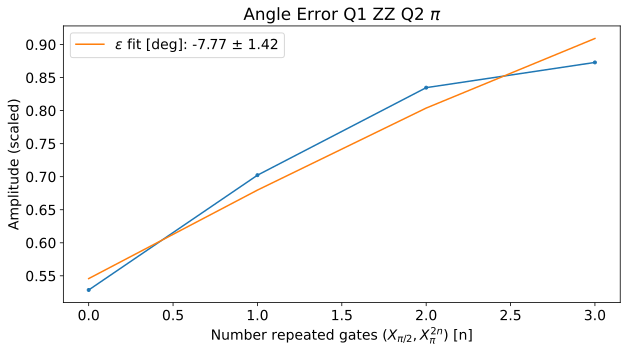

From avgi: adjust amplitude to 3309 / 1.0432085218542444 = 3171.9449474189864

From avgq: adjust amplitude to 3309 / 0.999749491184959 = 3309.829141376194


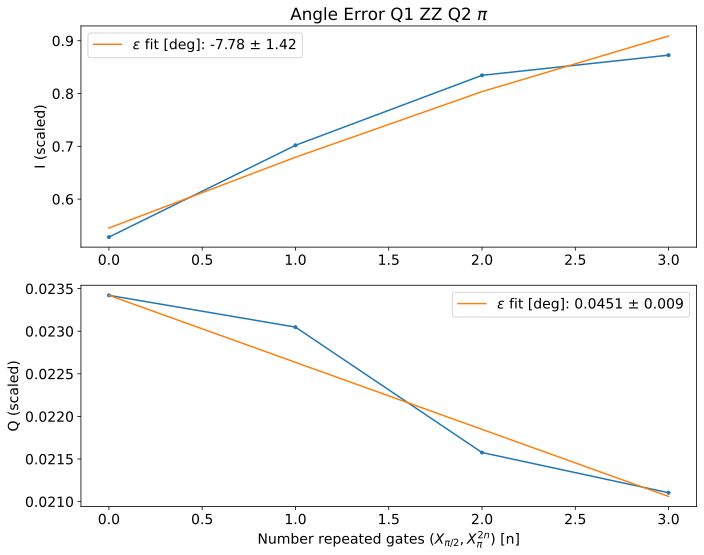

best 2 0.10608768025133404
updated pi_gain from error amplification 3310



######### BEGINNING QUBIT 1 WITH ZZ FROM 3 #########
initial pi_len 0.02
initial pi_gain 3274
initial pi_freq 3446.9608452525486
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.03970732848632781
Current pi pulse frequency: 3446.9608452525486
Fit frequency from amps [MHz]: 2.5592013659527595 +/- 0.0017393470543303757
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3446.9016438865956
 	3441.9016438865956
T2 Ramsey from fit amps [us]: 14.684891453395165 +/- 2.3725916424671176
Current pi pulse frequency: 3446.9608452525486
Fit frequency from I [MHz]: 2.5587200579368985 +/- 0.0018308958836649532
Suggested new pi pulse frequency from fit I [MHz]:
 	3446.9021251946115
 	3441.9021251946115
T2 Ramsey from fit I [us]: 14.912310894957816 +/- 2.576484999022038
Fit frequency from Q [MHz]: 2.5623078429765886 +/- 0.002174913862712151
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3446.898537409572
 	3441.898537409572
T2 Ramsey from fit Q [us]: 12.663475530151858 +/- 2.200029524348463


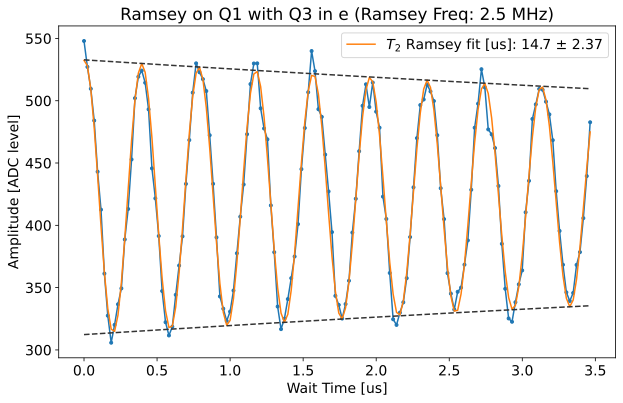

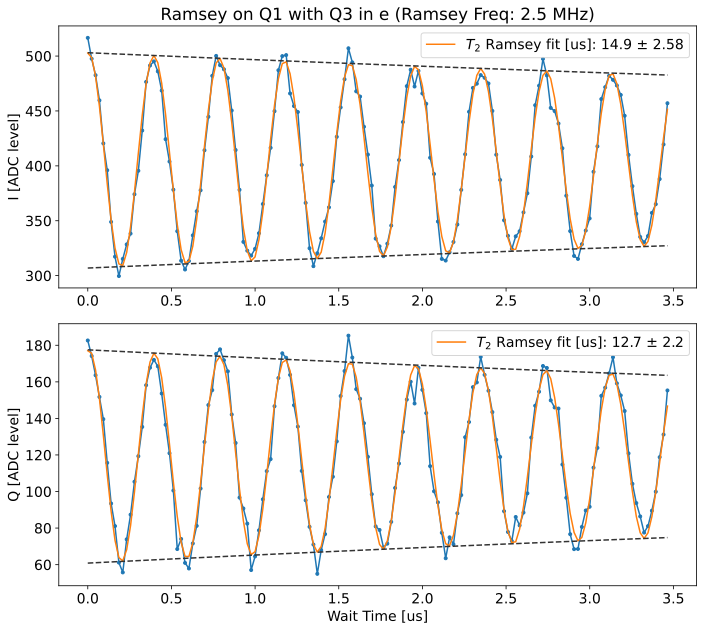

updated pi_freq 3446.9016438865956
-------- Error amplification --------


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 66.65555518517284 	 angle (deg): -40.12299448551103 	 threshold ge: 395.8577933446897


  0%|          | 0/20 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 359RuntimeWarning: divide by zero encountered in divide
 s:\Connie\experiments\qramLL_4QR2\experiments\single_qubit\length_rabi.py: 360

From amps: adjust amplitude to 3274 / 1.0452725583370193 = 3132.1974100312973


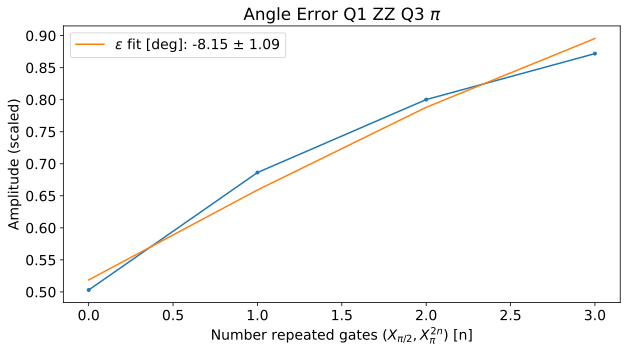

From avgi: adjust amplitude to 3274 / 1.0453225942118578 = 3132.047482881109

From avgq: adjust amplitude to 3274 / 0.9997523912018278 = 3274.8108719842535


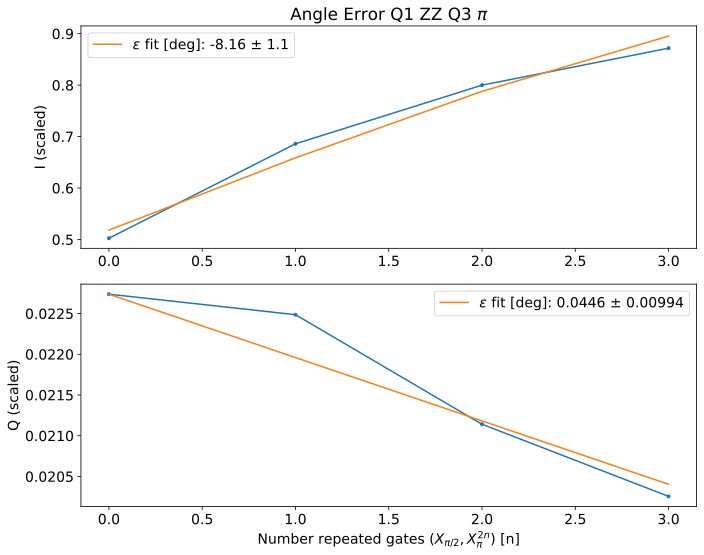

best 0 0.09257947479165142
updated pi_gain from error amplification 3132





In [167]:
try: save_data
except: assert False, 'you did not run the cell above!'

thresholds=None
angles=None
ge_avgs=None
counts_calib=None

for qZZ in range(4):
    for qTest in range(4):
        if 1 not in [qZZ, qTest]: continue
        # if not (qZZ == 0 and qTest == 1): continue
        # if 0 not in [qZZ, qTest]: continue
        # if 0 not in [qZZ, qTest] and 3 not in [qZZ, qTest]: continue

        if qZZ == qTest: continue

        print(f"######### BEGINNING QUBIT {qTest} WITH ZZ FROM {qZZ} #########")

        # ----- Default values ----- #
        if qTest == 1:
            pi_len = yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[qZZ]
            pi_gain = yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[qZZ]
            pi_freq = yaml_cfg.device.qubit.f_Q1_ZZ[qZZ]
        else:
            pi_len = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qTest]
            pi_gain = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qTest]
            pi_freq = yaml_cfg.device.qubit.f_Q_ZZ1[qTest]
        print('initial pi_len', pi_len)
        print('initial pi_gain', pi_gain)
        print('initial pi_freq', pi_freq)
        override = False

        # For each experiment, update the relevant local variable pi_x, update the yaml and pass it to the next function, update the results for the relevant variable


        # ----- Length Rabi ----- #
        if do_length_rabi or override:
            pi_len = run_length_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[qZZ] = pi_len
            else: yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qTest] = pi_len
            print('updated pi_len', pi_len)
            if qTest == 1: results['pi_Q1_ZZ_sigma'][qZZ] = pi_len
            else: results['pi_Q_ZZ1_sigma'][qTest] = pi_len
        override = False

        # ----- Amp Rabi ----- #
        # if qTest != 1: override = True
        if do_amp_rabi and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[qZZ] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qTest] = pi_gain
            print('updated pi_gain', pi_gain)
            if qTest == 1: results['pi_Q1_ZZ_gain'][qZZ] = pi_gain
            else: results['pi_Q_ZZ1_gain'][qTest] = pi_gain
        override = False

        # ----- Ramsey ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        if do_ramsey and not override:
            pi_freq = run_ramsey(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.f_Q1_ZZ[qZZ] = pi_freq
            else: yaml_cfg.device.qubit.f_Q_ZZ1[qTest] = pi_freq
            print('updated pi_freq', pi_freq)
            if qTest == 1: results['f_Q1_ZZ'][qZZ] = pi_freq
            else: results['f_Q_ZZ1'][qTest] = pi_freq
        override = False

        # ----- Amp Rabi Round 2 ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_amp_rabi_2 and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[qZZ] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qTest] = pi_gain
            print('updated pi_gain round 2', pi_gain)
            if qTest == 1: results['pi_Q1_ZZ_gain'][qZZ] = pi_gain
            else: results['pi_Q_ZZ1_gain'][qTest] = pi_gain
        override = False

        # ----- Error amplification ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_error_amp and not override:
            pi_gain = run_error_amp(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[qZZ] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qTest] = pi_gain
            print('updated pi_gain from error amplification', pi_gain)
            if qTest == 1: results['pi_Q1_ZZ_gain'][qZZ] = pi_gain
            else: results['pi_Q_ZZ1_gain'][qTest] = pi_gain
        override = False



        # ----- Update results ----- #
        if qTest == 1:
            results['pi_Q1_ZZ_gain'][qZZ] = pi_gain
            results['pi_Q1_ZZ_sigma'][qZZ] = pi_len
            results['f_Q1_ZZ'][qZZ] = pi_freq
        else:
            results['pi_Q_ZZ1_gain'][qTest] = pi_gain
            results['pi_Q_ZZ1_sigma'][qTest] = pi_len
            results['f_Q_ZZ1'][qTest] = pi_freq

        print("\n\n")

In [169]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: [', end='')
print(*(results['f_Q1_ZZ']), sep=', ', end=']\n')
print(f'f_Q_ZZ1: [', end='')
print(*(results['f_Q_ZZ1']), sep=', ', end=']\n')

print(f'pi_Q1_ZZ:\ngain: [', end='')
print(*(results['pi_Q1_ZZ_gain']), sep=', ', end=']\n')
print(f'sigma: [', end='')
print(*(results['pi_Q1_ZZ_sigma']), sep=', ', end=']\n')

print(f'pi_Q_ZZ1:\ngain: [', end='')
print(*(results['pi_Q_ZZ1_gain']), sep=', ', end=']\n')
print(f'sigma: [', end='')
print(*(results['pi_Q_ZZ1_sigma']), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3442.837979505655, 0, 3447.102664818869, 3446.9016438865956]
f_Q_ZZ1: [4105.061776980227, 0, 4761.0850337068905, 4380.355943299591]
pi_Q1_ZZ:
gain: [2839, 0, 3310, 3132]
sigma: [0.025, 0, 0.02, 0.02]
pi_Q_ZZ1:
gain: [1984, 0, 14379, 4641]
sigma: [0.02, 0, 0.015, 0.005]


first update the config. then also update the ZZ matrix using the better calibrated values

In [170]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [171]:
# ZZshifts = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz
f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ)
f_Q_ZZ1 = np.array(yaml_cfg.device.qubit.f_Q_ZZ1)

print(f'f_Q1_ZZ: [', end='')
print(*(f_Q1_ZZ), sep=', ', end=']\n')
print(f'f_Q_ZZ1: [', end='')
print(*(f_Q_ZZ1), sep=', ', end=']\n')

f_ge = np.array(yaml_cfg.device.qubit.f_ge)

ZZshifts[1, :] = f_Q1_ZZ - f_ge[1]
ZZshifts[:, 1] = f_Q_ZZ1 - f_ge

ZZshifts[1, 1] = 0
print(ZZshifts)

f_Q1_ZZ: [3442.837979505655, 0.0, 3447.102664818869, 3446.9016438865956]
f_Q_ZZ1: [4105.061776980227, 0.0, 4761.0850337068905, 4380.355943299591]
[[ 0.         -5.45824061 -0.10430714 -0.5526523 ]
 [-5.51534737  0.         -1.25066205 -1.45168299]
 [-0.10430714 -1.12041325  0.         -0.48324089]
 [-0.5526523  -1.29269783 -0.52759174  0.        ]]


In [172]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.458240611352267, -0.1043071446219983, -0.5526523031812758, -5.515347366312653, 0.0, -1.2506620530984947, -1.4516829853719173, -0.1043071446219983, -1.1204132499606203, 0.0, -0.48324088539629884, -0.5526523031812758, -1.2926978289897306, -0.5275917408453097, 0.0]


## Check EF with ZZ shifts

In [153]:
save_data = False
saved_files = []

In [150]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [144]:
results = dict(
    pi_ef_Q_ZZ1_gain = [0]*4,
    pi_ef_Q_ZZ1_sigma = [0]*4,
    f_ef_Q_ZZ1 = [0]*4,
)

In [145]:
do_length_rabi = False
do_amp_rabi = True
# do_ramsey = True
do_ramsey = True
# do_amp_rabi_2 = True
do_amp_rabi_2 = False
do_error_amp = False

# put an override=True flag to force skipping certain qubits

######### BEGINNING QUBIT 3 EF WITH ZZ FROM 1 #########
initial pi_len 0.01
initial pi_gain 1632
initial pi_freq 4206.965719137019
-------- Amp rabi --------
freq ZZ 3448.2763303756715 gain 2583
freq ge 4380.292188720704 gain 4779
freq test 4206.965718955994
[{"envelopes": [{"next_addr": 0, "envs": {}}, {"next_addr": 640, "envs": {"pi_qubitZZ": {"data": ["YAIAAG8CAAB/AgAAjwIAAJ8CAACwAgAAwQIAANICAADkAgAA9gIAAAkDAAAcAwAALwMAAEMDAABXAwAAbAMAAIEDAACWAwAArAMAAMMDAADaAwAA8QMAAAkEAAAhBAAAOgQAAFMEAABtBAAAhwQAAKEEAAC9BAAA2QQAAPUEAAASBQAALwUAAE0FAABsBQAAiwUAAKsFAADLBQAA7AUAAA0GAAAvBgAAUgYAAHYGAACaBgAAvgYAAOQGAAAKBwAAMAcAAFgHAACABwAAqQcAANIHAAD8BwAAJwgAAFMIAAB/CAAArQgAANoIAAAJCQAAOQkAAGkJAACaCQAAzAkAAP4JAAAyCgAAZgoAAJsKAADRCgAACAsAAEALAAB4CwAAsgsAAOwLAAAnDAAAZAwAAKEMAADfDAAAHQ0AAF0NAACeDQAA4A0AACIOAABmDgAAqw4AAPAOAAA3DwAAfg8AAMcPAAAQEAAAWxAAAKYQAADzEAAAQREAAI8RAADfEQAAMBIAAIISAADVEgAAKRMAAH4TAADUEwAAKxQAAIMUAADcFAAANxUAAJMVAADvFQAATRYAAKwWAAAMFwAAbRcAAM8XAAAzGAAAlxgAAP0YAABkGQAAyxkAADQaAACfGgAACh

  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.004612340656916265
Pi gain from amps data [dac units]: 1639
	Pi/2 gain from amps data [dac units]: 819
Pi gain from avgi data [dac units]: 1640
	Pi/2 gain from avgi data [dac units]: 820
Pi gain from avgq data [dac units]: 1617
	Pi/2 gain from avgq data [dac units]: 808


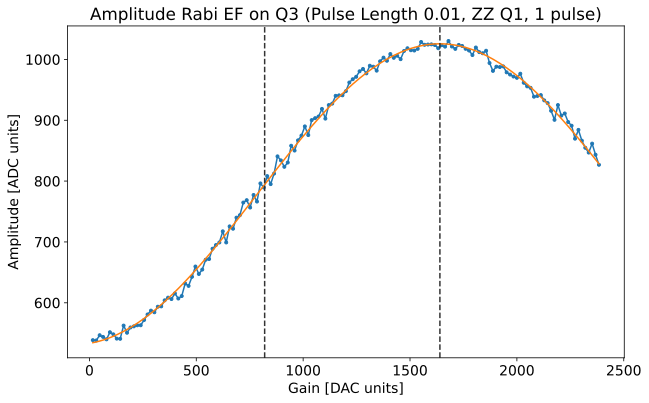

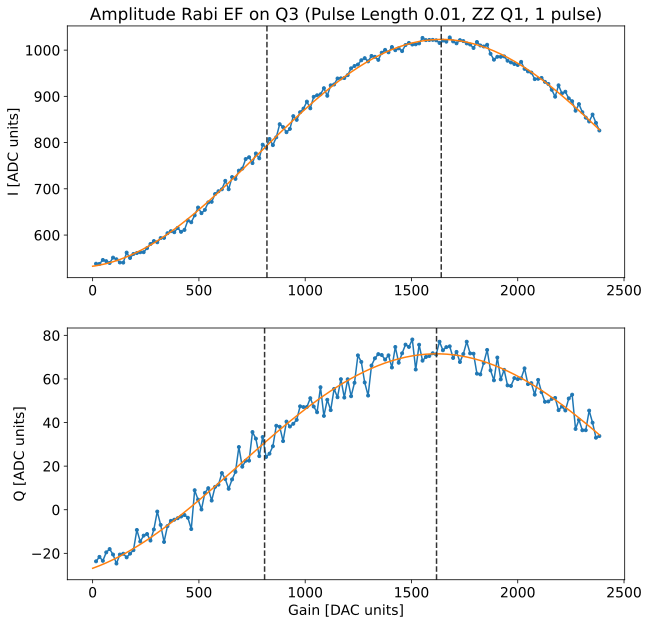

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00014_amp_rabi_qubit13.h5
updated pi_gain 1639
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.025486509201092196
Current pi pulse frequency: 4210.092796415932
Fit frequency from amps [MHz]: 2.2665278580187787 +/- 0.0014805556277947953
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4210.326268557913
 	4205.326268557913
T2 Ramsey from fit amps [us]: 10.31936914230699 +/- 1.000817719258498
Current pi pulse frequency: 4210.092796415932
Fit frequency from I [MHz]: 2.2665126433558314 +/- 0.0014855300764582207
Suggested new pi pulse frequency from fit I [MHz]:
 	4210.326283772576
 	4205.326283772576
T2 Ramsey from fit I [us]: 10.307398138055262 +/- 1.001854491235648
Fit frequency from Q [MHz]: 2.267845940729749 +/- 0.002538104966966769
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4210.324950475202
 	4205.324950475202
T2 Ramsey from fit Q [us]: 11.16858190606904 +/- 2.0093428667619024


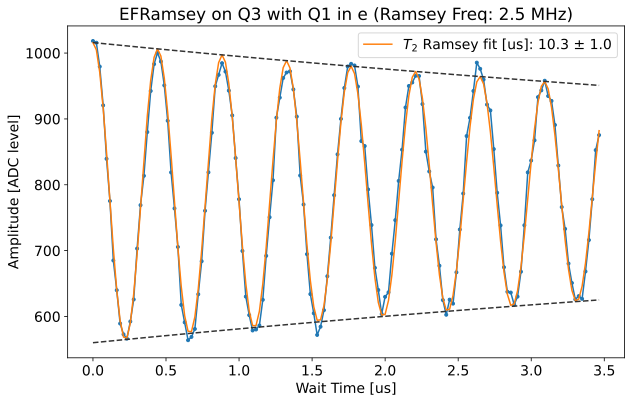

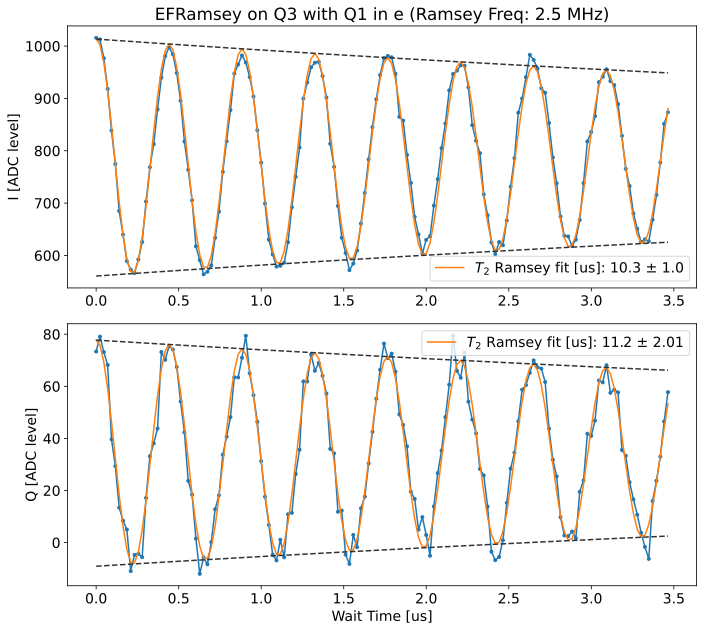

Saving s:\Connie\experiments\qramLL_4QR2\data\data_240617\00014_ramsey_qubit3.h5
updated pi_freq 4207.199191279





In [151]:
try: save_data
except: assert False, 'you did not run the cell above!'

thresholds=None
angles=None
ge_avgs=None
counts_calib=None

for qZZ in [1]:
    for qTest in [2, 3]:
    # for qTest in [3]:
        if 1 not in [qZZ, qTest]: continue
        # if not (qZZ == 0 and qTest == 1): continue
        # if 0 not in [qZZ, qTest]: continue
        # if 0 not in [qZZ, qTest] and 3 not in [qZZ, qTest]: continue

        if qZZ == qTest: continue

        print(f"######### BEGINNING QUBIT {qTest} EF WITH ZZ FROM {qZZ} #########")

        # ----- Default values ----- #
        pi_len = yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.sigma[qTest]
        pi_gain = yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.gain[qTest]
        pi_freq = yaml_cfg.device.qubit.f_ef_Q_ZZ1[qTest]
        print('initial pi_len', pi_len)
        print('initial pi_gain', pi_gain)
        print('initial pi_freq', pi_freq)
        override = False

        # For each experiment, update the relevant local variable pi_x, update the yaml and pass it to the next function, update the results for the relevant variable


        # ----- Length Rabi ----- #
        if do_length_rabi or override:
            pi_len = run_length_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_ef_Q1_ZZ.sigma[qZZ] = pi_len
            else: yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.sigma[qTest] = pi_len
            print('updated pi_len', pi_len)
            if qTest == 1: results['pi_ef_Q1_ZZ_sigma'][qZZ] = pi_len
            else: results['pi_ef_Q_ZZ1_sigma'][qTest] = pi_len
        override = False

        # ----- Amp Rabi ----- #
        # if qTest != 1: override = True
        if do_amp_rabi and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_ef_Q1_ZZ.gain[qZZ] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.gain[qTest] = pi_gain
            print('updated pi_gain', pi_gain)
            if qTest == 1: results['pi_ef_Q1_ZZ_gain'][qZZ] = pi_gain
            else: results['pi_ef_Q_ZZ1_gain'][qTest] = pi_gain
        override = False

        # ----- Ramsey ----- #
        # if 1 not in [qZZ, qTest]: override = True
        # if (qZZ == 1 and qTest == 0): override = True
        if do_ramsey and not override:
            pi_freq = run_ramsey(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.f_ef_Q1_ZZ[qZZ] = pi_freq
            else: yaml_cfg.device.qubit.f_ef_Q_ZZ1[qTest] = pi_freq
            print('updated pi_freq', pi_freq)
            if qTest == 1: results['f_ef_Q1_ZZ'][qZZ] = pi_freq
            else: results['f_ef_Q_ZZ1'][qTest] = pi_freq
        override = False

        # ----- Amp Rabi Round 2 ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_amp_rabi_2 and not override:
            pi_gain = run_amp_rabi(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_ef_Q1_ZZ.gain[qZZ] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.gain[qTest] = pi_gain
            print('updated pi_gain round 2', pi_gain)
            if qTest == 1: results['pi_ef_Q1_ZZ_gain'][qZZ] = pi_gain
            else: results['pi_ef_Q_ZZ1_gain'][qTest] = pi_gain
        override = False

        # ----- Error amplification ----- #
        # if qZZ == 0 and qTest == 1: override = True
        if do_error_amp and not override:
            pi_gain = run_error_amp(qZZ=qZZ, qTest=qTest, yaml_cfg=yaml_cfg, checkEF=True, save_data=save_data)
            if qTest == 1: yaml_cfg.device.qubit.pulses.pi_ef_Q1_ZZ.gain[qZZ] = pi_gain
            else: yaml_cfg.device.qubit.pulses.pi_ef_Q_ZZ1.gain[qTest] = pi_gain
            print('updated pi_gain from error amplification', pi_gain)
            if qTest == 1: results['pi_ef_Q1_ZZ_gain'][qZZ] = pi_gain
            else: results['pi_ef_Q_ZZ1_gain'][qTest] = pi_gain
        override = False



        # ----- Update results ----- #
        if qTest == 1:
            results['pi_ef_Q1_ZZ_gain'][qZZ] = pi_gain
            results['pi_ef_Q1_ZZ_sigma'][qZZ] = pi_len
            results['f_ef_Q1_ZZ'][qZZ] = pi_freq
        else:
            results['pi_ef_Q_ZZ1_gain'][qTest] = pi_gain
            results['pi_ef_Q_ZZ1_sigma'][qTest] = pi_len
            results['f_ef_Q_ZZ1'][qTest] = pi_freq

        print("\n\n")

In [152]:
print("UPDATE MANUALLY IN CONFIG:")
# print(f'f_ef_Q1_ZZ: [', end='')
# print(*(results['f_ef_Q1_ZZ']), sep=', ', end=']\n')
print(f'f_ef_Q_ZZ1: [', end='')
print(*(results['f_ef_Q_ZZ1']), sep=', ', end=']\n')

# print(f'pi_ef_Q1_ZZ:\ngain: [', end='')
# print(*(results['pi_ef_Q1_ZZ_gain']), sep=', ', end=']\n')
# print(f'sigma: [', end='')
# print(*(results['pi_ef_Q1_ZZ_sigma']), sep=', ', end=']\n')

print(f'pi_ef_Q_ZZ1:\ngain: [', end='')
print(*(results['pi_ef_Q_ZZ1_gain']), sep=', ', end=']\n')
print(f'sigma: [', end='')
print(*(results['pi_ef_Q_ZZ1_sigma']), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_ef_Q_ZZ1: [0, 0, 4570.466450039196, 4207.199191279]
pi_ef_Q_ZZ1:
gain: [0, 0, 9586, 1639]
sigma: [0, 0, 0.015, 0.01]


# Get couplings and bare qubit and ef frequencies by optimization

In [72]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [73]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [74]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [75]:
# gs_arr = [g01, g12, g13, g02, g03, g23]
def gs_mat_from_gs_arr(gs_arr):
    gs_matrix = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1
    gs_matrix[0, 1] = gs_arr[0]
    gs_matrix[1, 2] = gs_arr[1]
    gs_matrix[1, 3] = gs_arr[2]
    gs_matrix[0, 2] = gs_arr[3]
    gs_matrix[0, 3] = gs_arr[4]
    gs_matrix[2, 3] = gs_arr[5]
    gs_matrix += gs_matrix.transpose()
    return gs_matrix

In [76]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_fq_alpha_diff(fges_alphas_gs, *args):
    qubit_freqs, alphas_meas, ZZ_matrix = args # measured values
    fges = fges_alphas_gs[:4] 
    alphas = fges_alphas_gs[4:8] 
    gs = fges_alphas_gs[8:]
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs_mat_from_gs_arr(gs),
        qubit_freqs=fges,
        alphas=alphas,
        cutoffs=[3, 3, 3, 3],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    error_ZZ = np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)
    # error_ZZ = np.sum(np.abs(1e3*(abs(ZZ_matrix) - abs(qram.get_ZZ_matrix())))**2)
    error_fge = 0
    error_alpha = 0
    gstate = 'gggg'
    for i in range(4):
        estate = gstate[:i] + 'e' + gstate[i+1:]
        error_fge += np.sum(np.abs(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi - qubit_freqs[i])**2))
        fstate = gstate[:i] + 'f' + gstate[i+1:]
        error_alpha += np.sum(np.abs(1e3*(qram.get_base_wd(estate, fstate)/2/np.pi - (qubit_freqs[i] + alphas_meas[i]))**2))
    return error_ZZ + error_fge + error_alpha

In [77]:
gs_guess_MHz = np.array([50, 50, 50, 5, 5, 5])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
ef_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ef)
alphas_MHz = ef_freqs_MHz - qubit_freqs_MHz
ZZshifts_MHz = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz

delta_fq = 25e-3 # GHz away from measured
delta_alpha = 10e-3 # GHz away from measured
delta_g = 15e-3 # GHz away from measured
# x0 = np.array([*qubit_freqs_MHz, 50, 50, 50, 5, 5, 5])
x0 = np.array([*qubit_freqs_MHz, *alphas_MHz, *gs_guess_MHz])
print('x0', x0)
bounds_fq = [(1e-3*fq_MHz - delta_fq, 1e-3*fq_MHz + delta_fq) for fq_MHz in qubit_freqs_MHz]
bounds_alpha = [(1e-3*alpha_MHz - delta_alpha, 1e-3*alpha_MHz + delta_alpha) for alpha_MHz in alphas_MHz]
bounds_gs = [(np.max((0, 1e-3*g_MHz - delta_g)), 1e-3*g_MHz + delta_g) for g_MHz in gs_guess_MHz]
# bounds = [*bounds_fq, (10e-3, 100e-3), (10e-3, 100e-3), (10e-3, 100e-3), (1e-3, 50e-3), (1e-3, 50e-3), (1e-3, 50e-3)] # GHz
bounds = [*bounds_fq, *bounds_alpha, *bounds_gs] # GHz

result = minimize(ZZ_g_fq_alpha_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz), bounds=bounds , method='L-BFGS-B')
print(f'Success: {result.success}')

x0 [4110.12046887 3448.17890807 4762.24907399 4380.91982889 -225.15326618
 -100.41711901 -189.92090483 -172.85500426   50.           50.
   50.            5.            5.            5.        ]
Success: True


In [78]:
fges_alphas_gs_opt = result.x
fges_opt_MHz = fges_alphas_gs_opt[:4] * 1e3
alphas_opt_MHz = fges_alphas_gs_opt[4:8] * 1e3
gs_opt_MHz = fges_alphas_gs_opt[8:] * 1e3

qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=1e-3*gs_mat_from_gs_arr(gs_opt_MHz),
    qubit_freqs=1e-3*fges_opt_MHz,
    alphas=1e-3*alphas_opt_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured (coupled) qubits freqs [MHz]')
print(qubit_freqs_MHz)
print('Measured (coupled) ef freqs [MHz]')
print(ef_freqs_MHz)
print()

print('Optimized (uncoupled) qubit freqs [MHz]')
print(fges_opt_MHz)
print('Optimized (uncoupled) alphas [MHz]')
print(alphas_opt_MHz)

optimized_fges = []
optimized_fefs = []
gstate = 'gggg'
for i in range(4):
    estate = gstate[:i] + 'e' + gstate[i+1:]
    optimized_fges.append(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi))
    fstate = gstate[:i] + 'f' + gstate[i+1:]
    optimized_fefs.append(1e3*(qram.get_base_wd(estate, fstate)/2/np.pi))
print('Optimized (coupled) qubit freqs [MHz]')
print(optimized_fges)
print('Optimized (coupled) qubit ef freqs [MHz]')
print(optimized_fefs)
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]')
print('gs: [', end='')
print(*(gs_opt_MHz), sep=', ', end=']\n')
print()
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print('Measured ZZ matrix [MHz]')
print(ZZshifts_MHz)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print()
print(f'Optimization error: {ZZ_g_fq_alpha_diff(fges_alphas_gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz)}')

Measured (coupled) qubits freqs [MHz]
[4110.12046887 3448.17890807 4762.24907399 4380.91982889]
Measured (coupled) ef freqs [MHz]
[3884.9672027  3347.76178906 4572.32816916 4208.06482463]

Optimized (uncoupled) qubit freqs [MHz]
[4106.14726604 3456.6701284  4759.78012348 4378.87093728]
Optimized (uncoupled) alphas [MHz]
[-229.56066202 -102.2334172  -191.13666666 -174.38074586]
Optimized (coupled) qubit freqs [MHz]
[4110.120586304973, 3448.1788814568126, 4762.249285289085, 4380.919702140749]
Optimized (coupled) qubit ef freqs [MHz]
[3884.9671430996077, 3347.7613353261613, 4572.328257228266, 4208.064810483518]
Optimized g01, g12, g13, g02, g03, g23 [MHz]
gs: [52.41151277832647, 54.227062360553134, 44.64043444983635, 3.612297112825406, 2.5619407686581845, 6.059085014586995]

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.3462144  -0.10430714 -0.5526523 ]
 [-5.354118